## Results after 20 years of point pollution spill scenarios as part of MPRI-1

In [1]:
import os
import xarray as xr
import numpy as np
import pandas as pd
import itertools
import seaborn as sns
from pathlib import Path
import geopandas as gpd
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import ssam_groups as groups
import ssam_plot as splot

### Define scenario and control files

In [2]:
# Read in salish sea atlantis output files.
scenario_root = Path('/ocean/rlovindeer/MOAD/analysis-raisha/SSmodel_outputs/Spills/MPRI1')

control_file = "/ocean/rlovindeer/MOAD/analysis-raisha/SSmodel_outputs/Spills/Control/highres-control-3y-2039-2042/outputSalishSea.nc"
control = xr.open_dataset(str(control_file), decode_cf=True)
time = np.ma.filled(control.variables['t'], np.nan)

In [3]:
scenario_paths = sorted([p for p in scenario_root.glob('highres-2039-2042_*/outputSalishSea.nc')])
scenario_names = []
for path in scenario_paths:
    nm = str(path.parent.stem).split(sep='_')
    if nm[1] == '4a':
        scenario_loc = 'AP-'
    elif nm[1] == '5b':
        scenario_loc = 'TP-'
    elif nm[1] == '6a':
        scenario_loc = 'EB-'
    elif nm[1] == '7a':
        scenario_loc = 'JF-'
    scenario_names.append(scenario_loc+str(nm[2]))
    print(path.parent.stem, groups.conditions[str(path.parent.stem).split(sep = '_')[3]])

highres-2039-2042_4a_1_2019-07-04 low Fraser flow spring tide summer
highres-2039-2042_4a_2_2019-07-10 low Fraser flow neap tide summer
highres-2039-2042_4a_3_2020-07-22 high Fraser flow spring tide summer
highres-2039-2042_4a_4_2020-07-12 high Fraser flow neap tide summer
highres-2039-2042_5b_1_2019-01-20 low Fraser flow spring tide winter
highres-2039-2042_5b_2_2019-01-14 low Fraser flow neap tide winter
highres-2039-2042_5b_3_2020-01-24 high Fraser flow spring tide winter
highres-2039-2042_5b_4_2020-01-16 high Fraser flow neap tide winter
highres-2039-2042_6a_1_2019-07-16 low Fraser flow spring tide summer
highres-2039-2042_6a_2_2019-07-25 low Fraser flow neap tide summer
highres-2039-2042_6a_3_2020-07-21 high Fraser flow spring tide summer
highres-2039-2042_6a_4_2020-07-13 high Fraser flow neap tide summer
highres-2039-2042_7a_1_2019-01-21 low Fraser flow spring tide winter
highres-2039-2042_7a_2_2019-01-26 low Fraser flow neap tide winter
highres-2039-2042_7a_3_2020-01-11 high Fra

In [4]:
scenario_datasets = [xr.open_dataset(scen,decode_cf=True) for scen in scenario_paths]

In [5]:
zooplankton = {
    'microzooplankton':'MicroZoo', 'carnivorous zooplankton':'Carniv_Zoo', 'gelatinous zooplantkon':'Gelat_Zoo', 
    'mesozooplankton':'Zoo',
}

In [6]:
other_planktonic = {
    'pelagic bacteria':'Pelag_Bact',
    'squid':'Squid', 
}

In [18]:
def heatmap_plankton(location=groups.salish_sea, v_min=None, v_max=None):
    all_results = []
    for scenario, path in zip(scenario_datasets, scenario_paths):
        nm = str(path.parent.stem).split(sep='_')
        if nm[1] == '4a':
            scenario_name = 'AP-'+nm[2]
        elif nm[1] == '5b':
            scenario_name = 'TP-'+nm[2]
        elif nm[1] == '6a':
            scenario_name = 'EB-'+nm[2]
        elif nm[1] == '7a':
            scenario_name = 'JF-'+nm[2]

        z_oiled = 0
        z_control = 0
        p_oiled = 0
        p_control = 0

        for species in zooplankton:
            z_oiled = z_oiled + np.ma.filled(scenario.variables[zooplankton[species] + '_N'][:, location, 0:6], np.nan)
            z_control = z_control + np.ma.filled(control.variables[zooplankton[species] + '_N'][:, location, 0:6], np.nan)

        z_oiled_total = z_oiled.sum(axis=(1, 2)).mean()
        z_control_total = z_control.sum(axis=(1, 2)).mean()
        z_ratio = (z_oiled_total / z_control_total - 1) * 100

        all_results.append({
            'bio_group': 'Zooplankton',
            'scenario': scenario_name,
            'percent_change': z_ratio
        })
            
        for species in groups.phytoplankton:    
            p_oiled = p_oiled + np.ma.filled(scenario.variables[groups.phytoplankton[species] + '_N'][:, location, 0:6], np.nan)
            p_control = p_control + np.ma.filled(control.variables[groups.phytoplankton[species] + '_N'][:, location, 0:6], np.nan)
            
        p_oiled_total = p_oiled.sum(axis=(1, 2)).mean()
        p_control_total = p_control.sum(axis=(1, 2)).mean()
        p_ratio = (p_oiled_total / p_control_total - 1) * 100

        all_results.append({
            'bio_group': 'Phytoplankton',
            'scenario': scenario_name,
            'percent_change': p_ratio
        })

    df = pd.DataFrame(all_results)
    df.to_csv("/ocean/rlovindeer/MOAD/analysis-raisha/SSmodel_outputs/Spills/MPRI1/heatmap-plankton.csv")
    df_pivot = df.pivot_table(index='bio_group', 
                        columns='scenario', 
                        values='percent_change', 
                        )

    #sns.heatmap(df_pivot, annot=False, cmap='coolwarm_r', center=0)
    plt.figure(figsize=(14, len(df_pivot)*0.3))
    ax = sns.heatmap(df_pivot, annot=False, cmap='coolwarm_r', center=0, vmin=v_min, vmax=v_max,
    linewidths=0.5,
    #linecolor='gray',
    cbar_kws={'label': 'Percent Change'})
    location_boundaries = []
    prev_loc = None
    for i, col in enumerate(df_pivot.columns):
        loc = col.split('-')[0]
        if prev_loc is not None and loc != prev_loc:
            location_boundaries.append(i)
        prev_loc = loc

    for x in location_boundaries:
        ax.vlines(x, *ax.get_ylim(), colors='white', linewidth=4)

In [19]:
def heatmap_pelagic(bio_group, location=groups.salish_sea, v_min=None, v_max=None):
    all_results = []
    for scenario, path in zip(scenario_datasets, scenario_paths):
        nm = str(path.parent.stem).split(sep='_')
        if nm[1] == '4a':
            scenario_name = 'AP-'+nm[2]
        elif nm[1] == '5b':
            scenario_name = 'TP-'+nm[2]
        elif nm[1] == '6a':
            scenario_name = 'EB-'+nm[2]
        elif nm[1] == '7a':
            scenario_name = 'JF-'+nm[2]

        for species in bio_group:
            
            p_oiled = np.ma.filled(scenario.variables[bio_group[species] + '_N'][:, location, :], np.nan)
            p_control = np.ma.filled(control.variables[bio_group[species] + '_N'][:, location, :], np.nan)
            
            p_oiled = p_oiled.sum(axis=(1, 2)).mean()
            p_control = p_control.sum(axis=(1, 2)).mean()
            
            ratio = (p_oiled / p_control - 1) * 100

            all_results.append({
                'bio_group': bio_group[species],
                'scenario': scenario_name,
                'percent_change': ratio
            })

    df = pd.DataFrame(all_results)
    df.to_csv("/ocean/rlovindeer/MOAD/analysis-raisha/SSmodel_outputs/Spills/MPRI1/heatmap-"+str(bio_group[species])+".csv")
    df_pivot = df.pivot_table(index='bio_group', 
                        columns='scenario', 
                        values='percent_change', 
                        )

    #sns.heatmap(df_pivot, annot=False, cmap='coolwarm_r', center=0)
    plt.figure(figsize=(14, len(df_pivot)*0.3))
    ax = sns.heatmap(df_pivot, annot=False, cmap='coolwarm_r', center=0, vmin=v_min, vmax=v_max,
    linewidths=0.5,
    #linecolor='gray',
    cbar_kws={'label': 'Percent Change'})
    location_boundaries = []
    prev_loc = None
    for i, col in enumerate(df_pivot.columns):
        loc = col.split('-')[0]
        if prev_loc is not None and loc != prev_loc:
            location_boundaries.append(i)
        prev_loc = loc

    for x in location_boundaries:
        ax.vlines(x, *ax.get_ylim(), colors='white', linewidth=4)
    

In [20]:
def heatmap_vertebrates(bio_group, location=groups.salish_sea, v_min=None, v_max=None):
    all_results = []
    for scenario, path in zip(scenario_datasets, scenario_paths):
        nm = str(path.parent.stem).split(sep='_')
        if nm[1] == '4a':
            scenario_name = 'AP-'+nm[2]
        elif nm[1] == '5b':
            scenario_name = 'TP-'+nm[2]
        elif nm[1] == '6a':
            scenario_name = 'EB-'+nm[2]
        elif nm[1] == '7a':
            scenario_name = 'JF-'+nm[2]

        for species in bio_group:
            
            numCohorts = groups.cohorts[bio_group[species]]
            ratio = 0

            for cohort in range (1, numCohorts+1):

                new_species = bio_group[species] + str(cohort)
            
                o_numbers_tbl = np.ma.filled(scenario.variables[new_species + '_Nums'][:, location, 0:6], np.nan)
                o_structuralN_tbl = np.ma.filled(scenario.variables[new_species +'_StructN'][:, location, 0:6], np.nan)
                o_reservedN_tbl = np.ma.filled(scenario.variables[new_species +'_ResN'][:, location, 0:6], np.nan)

                c_numbers_tbl = np.ma.filled(control.variables[new_species + '_Nums'][:, location, 0:6], np.nan)
                c_structuralN_tbl = np.ma.filled(control.variables[new_species +'_StructN'][:, location, 0:6], np.nan)
                c_reservedN_tbl = np.ma.filled(control.variables[new_species +'_ResN'][:, location, 0:6], np.nan)

                o_weightatage_tbl = (o_structuralN_tbl + o_reservedN_tbl) * o_numbers_tbl 
                o_weightatage = o_weightatage_tbl.sum(axis=(1,2)).mean()

                c_weightatage_tbl = (c_structuralN_tbl + c_reservedN_tbl) * c_numbers_tbl 
                c_weightatage = c_weightatage_tbl.sum(axis=(1,2)).mean()

                cohort_ratio = (o_weightatage / c_weightatage - 1) * 100
                ratio = ratio + cohort_ratio

            mean_cohort_ratio = ratio/numCohorts

            all_results.append({
                'bio_group': bio_group[species],
                'scenario': scenario_name,
                'percent_change': mean_cohort_ratio
            })

    df = pd.DataFrame(all_results)
    df.to_csv("/ocean/rlovindeer/MOAD/analysis-raisha/SSmodel_outputs/Spills/MPRI1/heatmap-"+str(bio_group[species])+".csv")
    df_pivot = df.pivot_table(index='bio_group', 
                        columns='scenario', 
                        values='percent_change', 
                        )

    #sns.heatmap(df_pivot, annot=False, cmap='coolwarm_r', center=0)
    plt.figure(figsize=(14, len(df_pivot)*0.3))
    ax = sns.heatmap(df_pivot, annot=False, cmap='coolwarm_r', center=0, vmin=v_min, vmax=v_max,
    linewidths=0.5,
    #linecolor='gray',
    cbar_kws={'label': 'Percent Change'})
    location_boundaries = []
    prev_loc = None
    for i, col in enumerate(df_pivot.columns):
        loc = col.split('-')[0]
        if prev_loc is not None and loc != prev_loc:
            location_boundaries.append(i)
        prev_loc = loc

    for x in location_boundaries:
        ax.vlines(x, *ax.get_ylim(), colors='white', linewidth=4)
    

In [21]:
def heatmap_benthic(bio_group, location=groups.salish_sea, v_min=None, v_max=None):
    all_results = []
    for scenario, path in zip(scenario_datasets, scenario_paths):
        nm = str(path.parent.stem).split(sep='_')
        if nm[1] == '4a':
            scenario_name = 'AP-'+nm[2]
        elif nm[1] == '5b':
            scenario_name = 'TP-'+nm[2]
        elif nm[1] == '6a':
            scenario_name = 'EB-'+nm[2]
        elif nm[1] == '7a':
            scenario_name = 'JF-'+nm[2]

        for species in bio_group:
            
            p_oiled = np.ma.filled(scenario.variables[bio_group[species] + '_N'][:, location], np.nan)
            p_control = np.ma.filled(control.variables[bio_group[species] + '_N'][:, location], np.nan)
            
            p_oiled = p_oiled.sum(axis=(1)).mean()
            p_control = p_control.sum(axis=(1)).mean()
            
            ratio = (p_oiled / p_control - 1) * 100

            all_results.append({
                'bio_group': bio_group[species],
                'scenario': scenario_name,
                'percent_change': ratio
            })

    df = pd.DataFrame(all_results)
    df.to_csv("/ocean/rlovindeer/MOAD/analysis-raisha/SSmodel_outputs/Spills/MPRI1/heatmap-"+str(bio_group[species])+".csv")
    df_pivot = df.pivot_table(index='bio_group', 
                        columns='scenario', 
                        values='percent_change', 
                        #aggfunc='mean').sort_index(ascending=False
                        )

    plt.figure(figsize=(14, len(df_pivot)*0.3))
    ax = sns.heatmap(df_pivot, annot=False, cmap='coolwarm_r', center=0, vmin=v_min, vmax=v_max,
    linewidths=0.5,
    #linecolor='gray',
    cbar_kws={'label': 'Percent Change'})
    location_boundaries = []
    prev_loc = None
    for i, col in enumerate(df_pivot.columns):
        loc = col.split('-')[0]
        if prev_loc is not None and loc != prev_loc:
            location_boundaries.append(i)
        prev_loc = loc

    for x in location_boundaries:
        ax.vlines(x, *ax.get_ylim(), colors='white', linewidth=4)
    
    

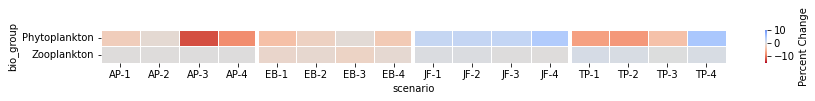

In [14]:
heatmap_plankton()

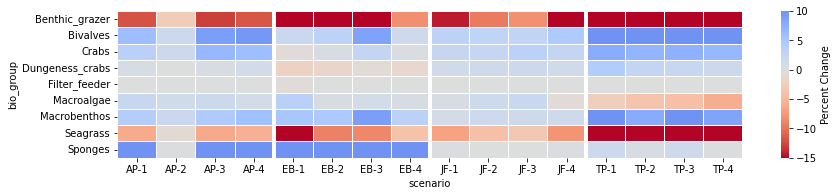

In [17]:
heatmap_benthic(groups.benthos)

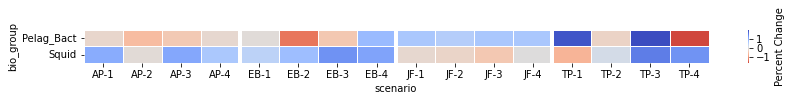

In [22]:
heatmap_pelagic(other_planktonic)

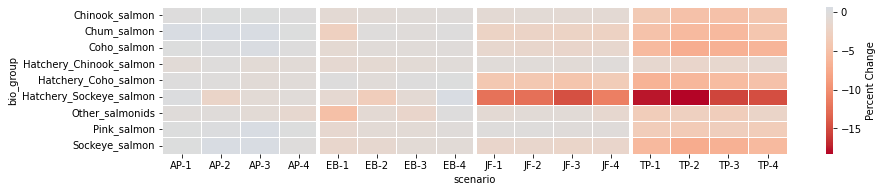

In [23]:
heatmap_vertebrates(groups.salmon)

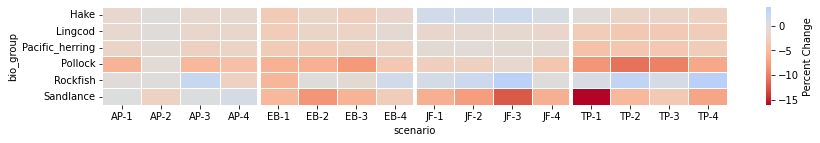

In [24]:
heatmap_vertebrates(groups.named_fish)

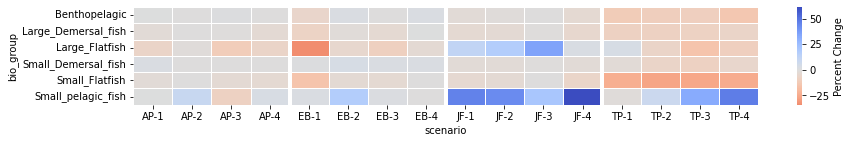

In [25]:
heatmap_vertebrates(groups.other_fish)

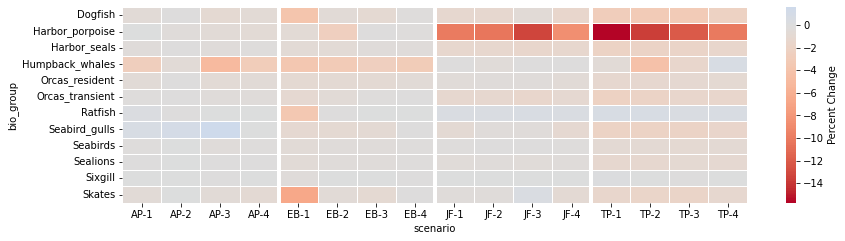

In [26]:
heatmap_vertebrates(groups.large_verts)

In [30]:
results_root = Path('/ocean/rlovindeer/MOAD/analysis-raisha/SSmodel_outputs/Spills/MPRI1/')
results_paths = sorted([p for p in results_root.glob('heatmap-*.csv')])
all_results = []
for file in results_paths:
    df = pd.read_csv(file)
    all_results.append(df[['bio_group', 'scenario', 'percent_change']])

combined_df = pd.concat(all_results, ignore_index=True)
combined_df.to_csv("/ocean/rlovindeer/MOAD/analysis-raisha/SSmodel_outputs/Spills/MPRI1/all_results.csv")

# Start from here

In [28]:
combined_df = pd.read_csv("/ocean/rlovindeer/MOAD/analysis-raisha/SSmodel_outputs/Spills/MPRI1/all_results.csv")

In [31]:
heatmap_data = combined_df.pivot(index='bio_group', columns='scenario', values='percent_change')
custom_order = ['Macroalgae', 'Seagrass', 'Pelag_Bact','Phytoplankton',
    'Zooplankton', 'Squid', 
    
    'Small_pelagic_fish',  'Small_Demersal_fish', 'Small_Flatfish', 
    'Benthopelagic', 'Large_Demersal_fish', 'Large_Flatfish','Rockfish',
    'Hake','Lingcod', 'Pollock', 'Sandlance','Pacific_herring', 
    'Chinook_salmon', 'Chum_salmon', 'Coho_salmon','Pink_salmon','Sockeye_salmon', 
    'Hatchery_Chinook_salmon','Hatchery_Coho_salmon','Hatchery_Sockeye_salmon','Other_salmonids',
    
    'Benthic_grazer', 'Filter_feeder', 'Macrobenthos',  
    'Sponges', 'Bivalves', 'Crabs', 'Dungeness_crabs',
    
    'Dogfish','Ratfish','Sixgill','Skates',

    'Harbor_porpoise', 'Harbor_seals', 'Sealions',
    'Orcas_resident', 'Orcas_transient','Humpback_whales',
    
    'Seabird_gulls','Seabirds',]
heatmap_data = heatmap_data.reindex(custom_order)

In [32]:
sensitivity = {'Macroalgae':1.4, 'Seagrass':6.1, 'Pelag_Bact':0.1,'Phytoplankton':0.3,'Zooplankton':0.2, 'Squid':0.1, 
    
    'Small_pelagic_fish':1.1,  'Small_Demersal_fish':0.1, 'Small_Flatfish':0.6, 
    'Benthopelagic':0.2, 'Large_Demersal_fish':0.3, 'Large_Flatfish':0.1,'Rockfish':1.2,
    'Hake':0.4,'Lingcod':0.1, 'Pollock':0.1, 'Sandlance':0.6,'Pacific_herring':0.2, 
    'Chinook_salmon':0.4, 'Chum_salmon':0.4, 'Coho_salmon':0.1,'Pink_salmon':0.1,'Sockeye_salmon':0.7, 
    'Hatchery_Chinook_salmon':0.1,'Hatchery_Coho_salmon':0.1,'Hatchery_Sockeye_salmon':0.2,'Other_salmonids':0.1,
    
    'Benthic_grazer':9.6, 'Filter_feeder':0.1, 'Macrobenthos':1.8,  
    'Sponges':0.1, 'Bivalves':0.1, 'Crabs':0.6, 'Dungeness_crabs':0.2,
    
    'Dogfish':0.1,'Ratfish':0.1,'Sixgill':0.1,'Skates':0.1,

    'Harbor_porpoise':0.4, 'Harbor_seals':0.1, 'Sealions':0.3,
    'Orcas_resident':0.1, 'Orcas_transient':0.1,'Humpback_whales':0.1,
    
    'Seabird_gulls':1.3,'Seabirds':0.2,
    
    'benthic_invertebrates':0.5,'marine_plants':2, 'seabirds':1.2, 'cetaceans':0.4, 'salmon':0.6,
    'demersal_fish'	:0.2,'pelagic_fish'	:0.3,'pinnipeds':0.1,'plankton':0.1,'elasmobranchs':0.1,
    }

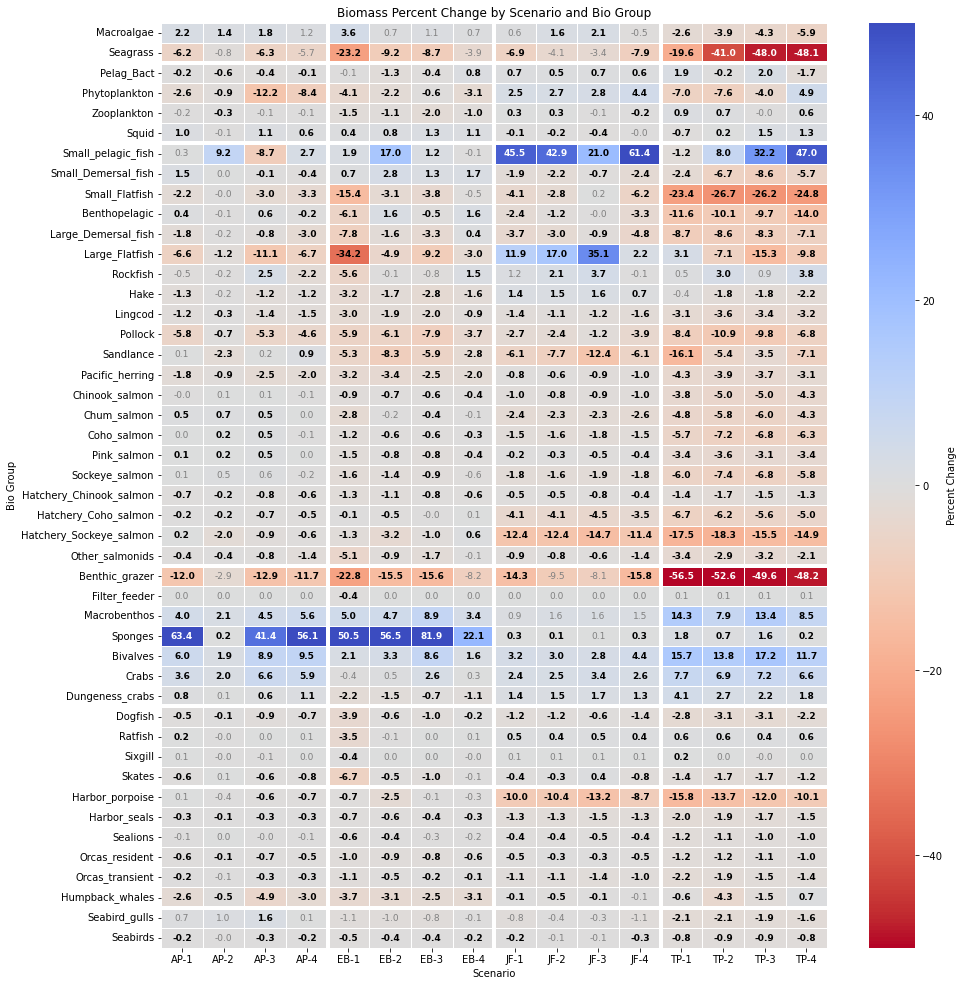

In [41]:
# Full data for Supplement
plt.figure(figsize=(14, len(heatmap_data)*0.3))
ax = sns.heatmap(
    heatmap_data,
    annot=False,
    fmt=".1f",
    cmap="coolwarm_r", 
    center=0, vmin=-50, vmax=50,
    linewidths=0.5,
    #linecolor='gray',
    cbar_kws={'label': 'Percent Change'}
)

for y_idx, bio_group in enumerate(heatmap_data.index):
    for x_idx, scenario in enumerate(heatmap_data.columns):
        value = heatmap_data.loc[bio_group, scenario]

        # Determine annotation style
        bold = False
        if bio_group in sensitivity:
            try:
                if np.abs(value) > sensitivity[bio_group]:
                    bold = True
            except:
                pass  # if value is NaN or non-numeric

        fontweight = 'bold' if bold else 'normal'
        text_color = 'black' if bold else 'gray'
        if np.abs(value) > 40:
            text_color = 'white'

        ax.text(
            x_idx + 0.5,
            y_idx + 0.5,
            f"{value:.1f}" if not np.isnan(value) else "",
            ha='center',
            va='center',
            fontsize=9,
            fontweight=fontweight,
            color=text_color
        )


bio_boundaries = [2, 6, 27, 34, 38, 44]

location_boundaries = []
prev_loc = None
for i, col in enumerate(heatmap_data.columns):
    loc = col.split('-')[0]
    if prev_loc is not None and loc != prev_loc:
        location_boundaries.append(i)
    prev_loc = loc

for x in location_boundaries:
    ax.vlines(x, *ax.get_ylim(), colors='white', linewidth=4)

for y in bio_boundaries:
    ax.hlines(y, *ax.get_xlim(), colors='white', linewidth=4)
    
plt.title("Biomass Percent Change by Scenario and Bio Group")
plt.xlabel("Scenario")
plt.ylabel("Bio Group")
plt.tight_layout()
plt.show()

In [35]:
heatmap_data.to_csv("/ocean/rlovindeer/MOAD/analysis-raisha/SSmodel_outputs/Spills/MPRI1/heatmap_data.csv")

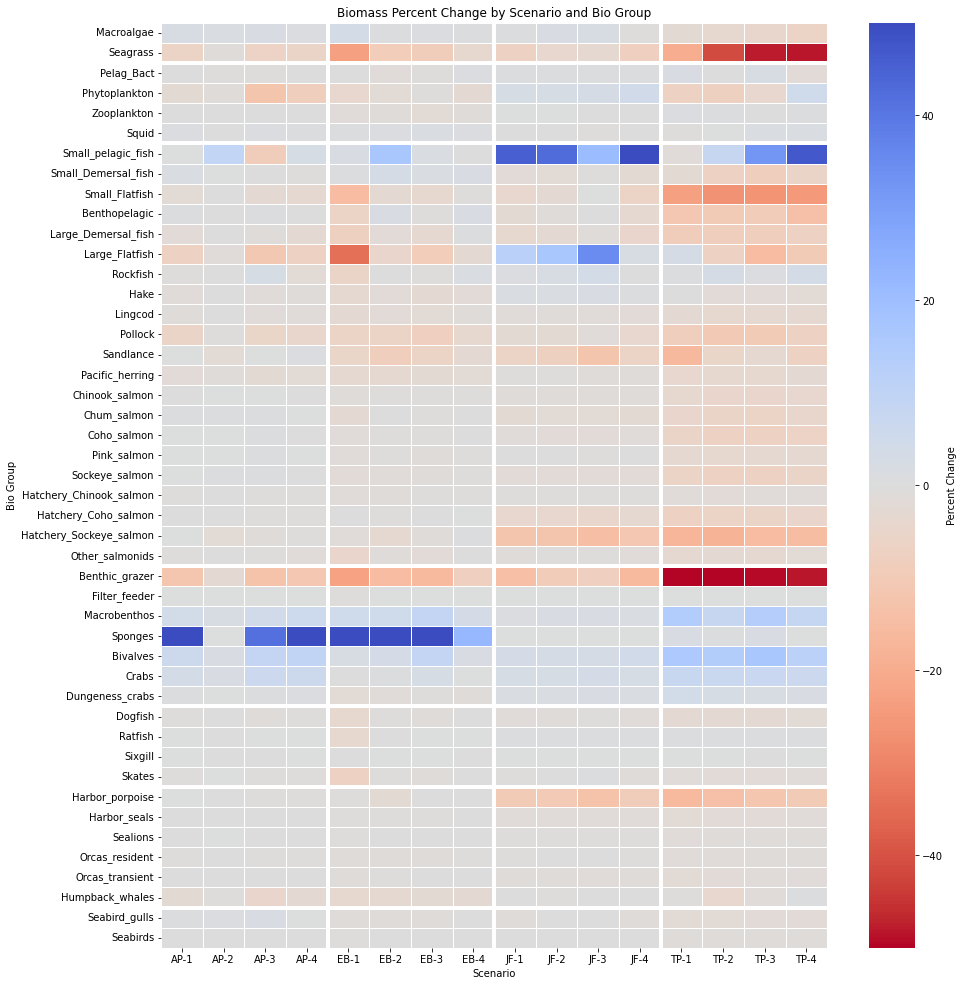

In [42]:
#Heatmap for Paper
plt.figure(figsize=(14, len(heatmap_data)*0.3))
ax = sns.heatmap(
    heatmap_data,
    annot=False,
    fmt=".1f",
    cmap="coolwarm_r", 
    center=0, vmin=-50, vmax=50,
    linewidths=0.5,
    cbar_kws={'label': 'Percent Change'}
)

location_boundaries = []
prev_loc = None
for i, col in enumerate(heatmap_data.columns):
    loc = col.split('-')[0]
    if prev_loc is not None and loc != prev_loc:
        location_boundaries.append(i)
    prev_loc = loc

for x in location_boundaries:
    ax.vlines(x, *ax.get_ylim(), colors='white', linewidth=4)

for y in bio_boundaries:
    ax.hlines(y, *ax.get_xlim(), colors='white', linewidth=4)
    
plt.title("Biomass Percent Change by Scenario and Bio Group")
plt.xlabel("Scenario")
plt.ylabel("Bio Group")
plt.tight_layout()
plt.show()

Aggregated data for Presentation

In [ ]:
aggregated_df = pd.read_csv("/ocean/rlovindeer/MOAD/analysis-raisha/SSmodel_outputs/Spills/MPRI1/aggregated_data.csv")

In [ ]:
aggregated_df = aggregated_df.loc[aggregated_df.time_label=='20 years later']
df_pivot = aggregated_df.pivot_table(index='bio_group', 
                        columns='scenario', 
                        values='percent_change', 
                        #aggfunc='mean').sort_index(ascending=False
                        )
plt.figure(figsize=(14, len(df_pivot)*0.3))
ax = sns.heatmap(df_pivot, annot=False, cmap='coolwarm_r', center=0, vmin=None, vmax=None,
linewidths=0.5,
#linecolor='gray',
cbar_kws={'label': 'Percent Change'})
location_boundaries = []
prev_loc = None
for i, col in enumerate(df_pivot.columns):
    loc = col.split('-')[0]
    if prev_loc is not None and loc != prev_loc:
        location_boundaries.append(i)
    prev_loc = loc

for x in location_boundaries:
    ax.vlines(x, *ax.get_ylim(), colors='white', linewidth=4)                        

In [ ]:
df_pivot

In [ ]:
aggregated_heatmap_data = aggregated_df.pivot(index='bio_group', columns='scenario', values='percent_change')
custom_order = ['plankton', 'pelagic_fish', 'salmon', 'pinnipeds','cetaceans','elasmobranchs','demersal_fish','benthic_invertebrates','marine_plants','seabirds'] 
aggregated_heatmap_data = aggregated_heatmap_data.reindex(custom_order)

In [ ]:
plt.figure(figsize=(12, len(aggregated_heatmap_data)*0.4))
ax = sns.heatmap(
    aggregated_heatmap_data,
    annot=False,
    fmt=".1f",
    cmap="coolwarm_r", 
    center=0, vmin=None, vmax=None,
    linewidths=0.5,
    cbar_kws={'label': 'Percent Change'}
)


for y_idx, bio_group in enumerate(aggregated_heatmap_data.index):
    for x_idx, scenario in enumerate(aggregated_heatmap_data.columns):
        value = aggregated_heatmap_data.loc[bio_group, scenario]

        # Determine annotation style
        bold = False
        if bio_group in sensitivity:
            try:
                if np.abs(value) > sensitivity[bio_group]:
                    bold = True
            except:
                pass  # if value is NaN or non-numeric

        fontweight = 'bold' if bold else 'normal'
        text_color = 'gray' if bold else 'white'
        #if np.abs(value) > 12:
        #    text_color = 'white'

        ax.text(
            x_idx + 0.5,
            y_idx + 0.5,
            f"{value:.1f}" if not np.isnan(value) else "",
            ha='center',
            va='center',
            fontsize=9,
            fontweight=fontweight,
            color=text_color
        )
location_boundaries = []
prev_loc = None
        
for i, col in enumerate(df_pivot.columns):
    loc = col.split('-')[0]
    if prev_loc is not None and loc != prev_loc:
        location_boundaries.append(i)
    prev_loc = loc

for x in location_boundaries:
    ax.vlines(x, *ax.get_ylim(), colors='white', linewidth=4
)
plt.tight_layout()
plt.yticks(fontsize=12)
plt.xticks(fontsize=10)
plt.show()

In [ ]:
plt.figure(figsize=(12, len(aggregated_heatmap_data)*0.4))
ax = sns.heatmap(
    aggregated_heatmap_data,
    annot=False,
    fmt=".1f",
    cmap="coolwarm_r", 
    center=0, vmin=None, vmax=None,
    linewidths=0.5,
    cbar_kws={'label': 'Percent Change'}
)

location_boundaries = []
prev_loc = None
        
for i, col in enumerate(df_pivot.columns):
    loc = col.split('-')[0]
    if prev_loc is not None and loc != prev_loc:
        location_boundaries.append(i)
    prev_loc = loc

for x in location_boundaries:
    ax.vlines(x, *ax.get_ylim(), colors='white', linewidth=4
)
plt.tight_layout()
plt.yticks(fontsize=12)
plt.xticks(fontsize=10)
plt.show()